# V3: Embedding空間分布

学習済みToken EmbeddingとPosition Embeddingの分布を可視化し、モデルが獲得した表現空間を理解します。

特に、文字の音韻的特徴とPython記号の構造的関係がEmbedding空間でどのようにクラスタリングされているかを確認します。

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from model_analyzer import ModelAnalyzer, InferenceEngine

# Seabornのスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
import japanize_matplotlib  # 日本語表示を有効化

## ModelAnalyzerの初期化

In [2]:
# モデルの読み込み
analyzer = ModelAnalyzer('../model.json')

モデル読み込み完了: vocab_size=27, n_layer=1, n_embd=16, block_size=16, n_head=4


## セクション1：Token Embedding可視化

### 1-1: 2次元投影（PCA）

In [3]:
# Token Embeddingを取得
token_emb = analyzer.get_embedding_matrix('token')
print(f"Token Embedding shape: {token_emb.shape}")

# PCAで2次元に投影
pca = PCA(n_components=2)
token_emb_2d = pca.fit_transform(token_emb)
print(f"PCA説明分散比: {pca.explained_variance_ratio_}")
print(f"累積寄与率: {sum(pca.explained_variance_ratio_):.2%}")

# 音韻的カテゴリとPython記号の詳細カテゴリを取得
char_categories = analyzer.get_phonetic_categories_dict()

# カラーマップを定義（11カテゴリ）
category_colors = {
    'vowels': '#e74c3c',           # 赤色系
    'plosives': '#3498db',         # 青色系
    'fricatives': '#2ecc71',       # 緑色系
    'sonorants': '#e67e22',        # 橙色系
    'approximants': '#9b59b6',     # 紫色系
    'round_brackets': '#5dade2',   # 明るい青色系
    'square_brackets': '#52be80',  # 明るい緑色系
    'curly_brackets': '#af7ac5',   # 明るい紫色系
    'operators': '#c0392b',        # 濃い赤色系
    'delimiters': '#8b4513',       # 茶色系
    'quotes': '#ec7063',           # ピンク色系
    'whitespace_other': '#95a5a6'  # 灰色系
}

# データフレームを作成
token_df = pd.DataFrame({
    'PC1': token_emb_2d[:, 0],
    'PC2': token_emb_2d[:, 1],
    'char': analyzer.uchars + ['<BOS>'],
    'category': [char_categories.get(ch, 'whitespace_other') for ch in analyzer.uchars] + ['whitespace_other']
})

Token Embedding shape: (27, 16)
PCA説明分散比: [0.35479791 0.15940092]
累積寄与率: 51.42%


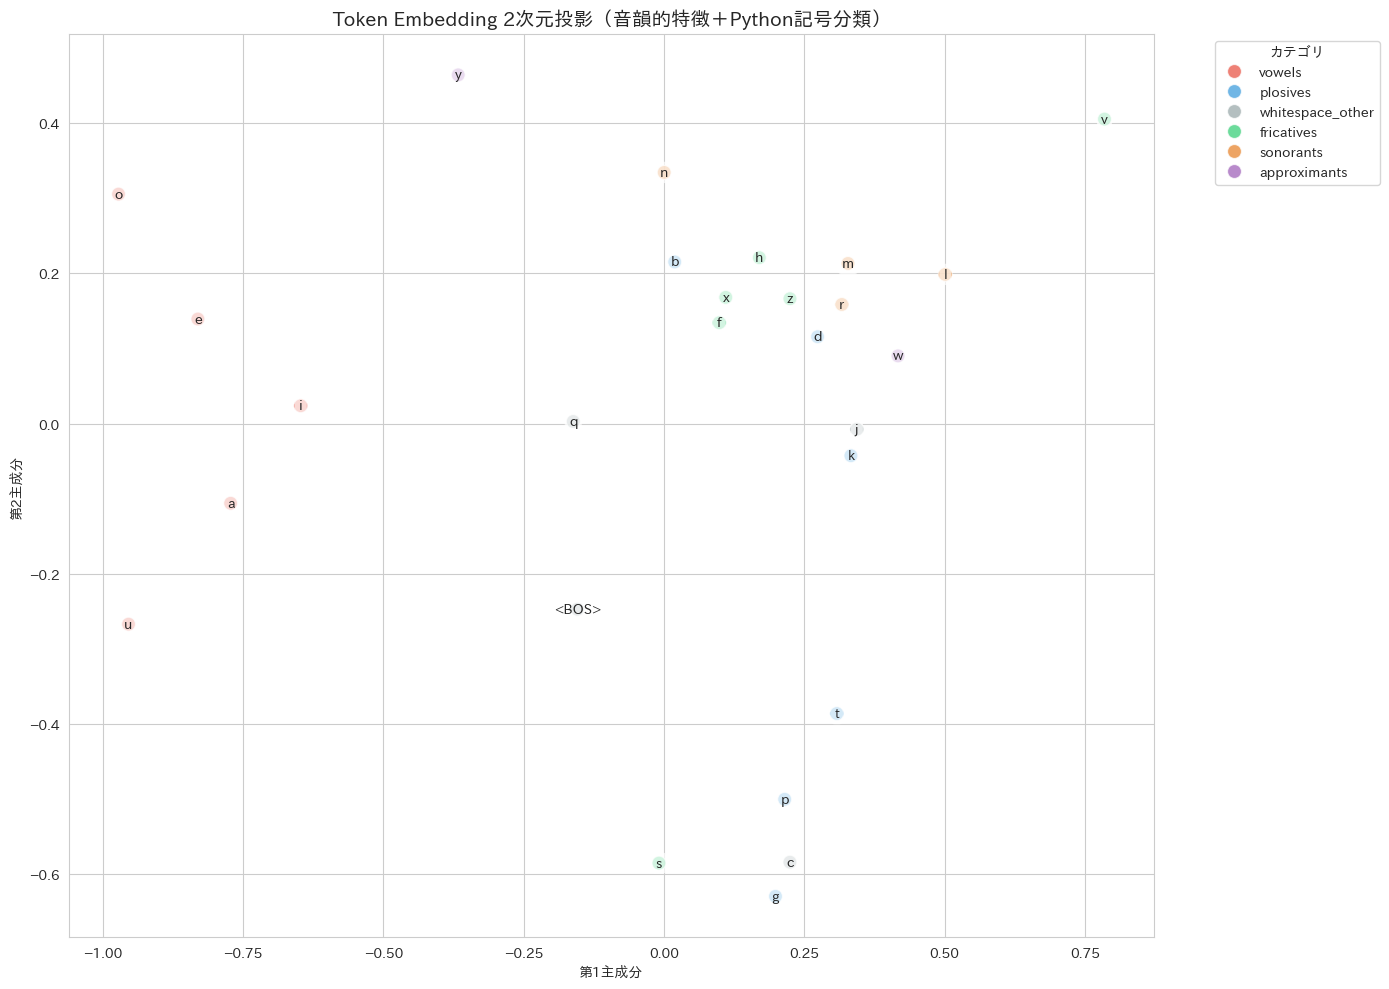


注目: 対応する括弧（[と]、(と)、{と}）が近い位置にあることを確認してください


In [4]:
# Seabornで散布図を作成
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=token_df,
    x='PC1',
    y='PC2',
    hue='category',
    palette=category_colors,
    s=100,
    alpha=0.7
)

# 各点にラベルを表示
for idx, row in token_df.iterrows():
    plt.text(row['PC1'], row['PC2'], row['char'], 
             fontsize=10, ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Token Embedding 2次元投影（音韻的特徴＋Python記号分類）', fontsize=14)
plt.xlabel('第1主成分')
plt.ylabel('第2主成分')
plt.legend(title='カテゴリ', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n注目: 対応する括弧（[と]、(と)、{と}）が近い位置にあることを確認してください")

### 1-2: Plotlyインタラクティブ散布図

In [5]:
# Plotlyでインタラクティブな散布図を作成
fig = go.Figure()

# カテゴリごとにトレースを追加
for category in token_df['category'].unique():
    df_cat = token_df[token_df['category'] == category]
    fig.add_trace(go.Scatter(
        x=df_cat['PC1'],
        y=df_cat['PC2'],
        mode='markers+text',
        name=category,
        text=df_cat['char'],
        textposition='middle center',
        marker=dict(
            size=15,
            color=category_colors.get(category, '#95a5a6'),
            line=dict(width=1, color='white')
        ),
        hovertemplate='<b>%{text}</b><br>カテゴリ: ' + category + '<br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<extra></extra>'
    ))

fig.update_layout(
    title='Token Embedding 2次元投影（インタラクティブ）',
    xaxis_title='第1主成分',
    yaxis_title='第2主成分',
    width=1000,
    height=800,
    hovermode='closest'
)

fig.show()

### 1-3: 次元別の重み分布

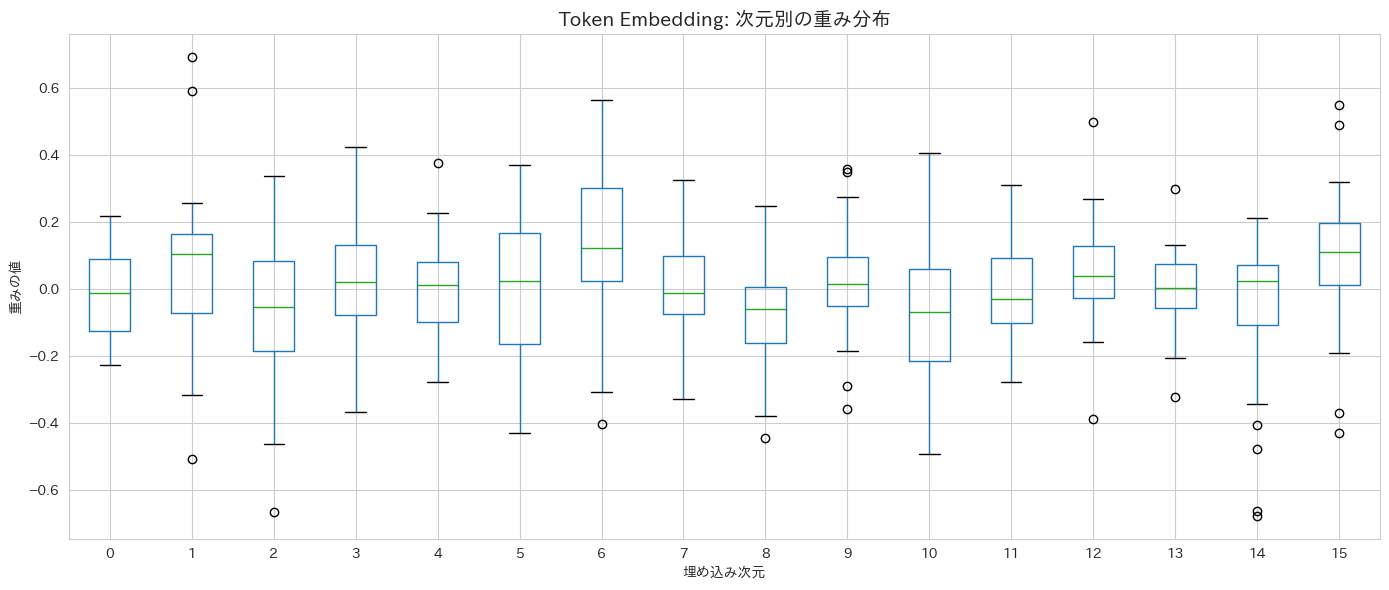

In [6]:
# 各次元の重み分布を可視化
plt.figure(figsize=(14, 6))
token_emb_df = pd.DataFrame(token_emb)
token_emb_df.boxplot()
plt.title('Token Embedding: 次元別の重み分布', fontsize=14)
plt.xlabel('埋め込み次元')
plt.ylabel('重みの値')
plt.tight_layout()
plt.show()

### 1-4: トークン間類似度行列

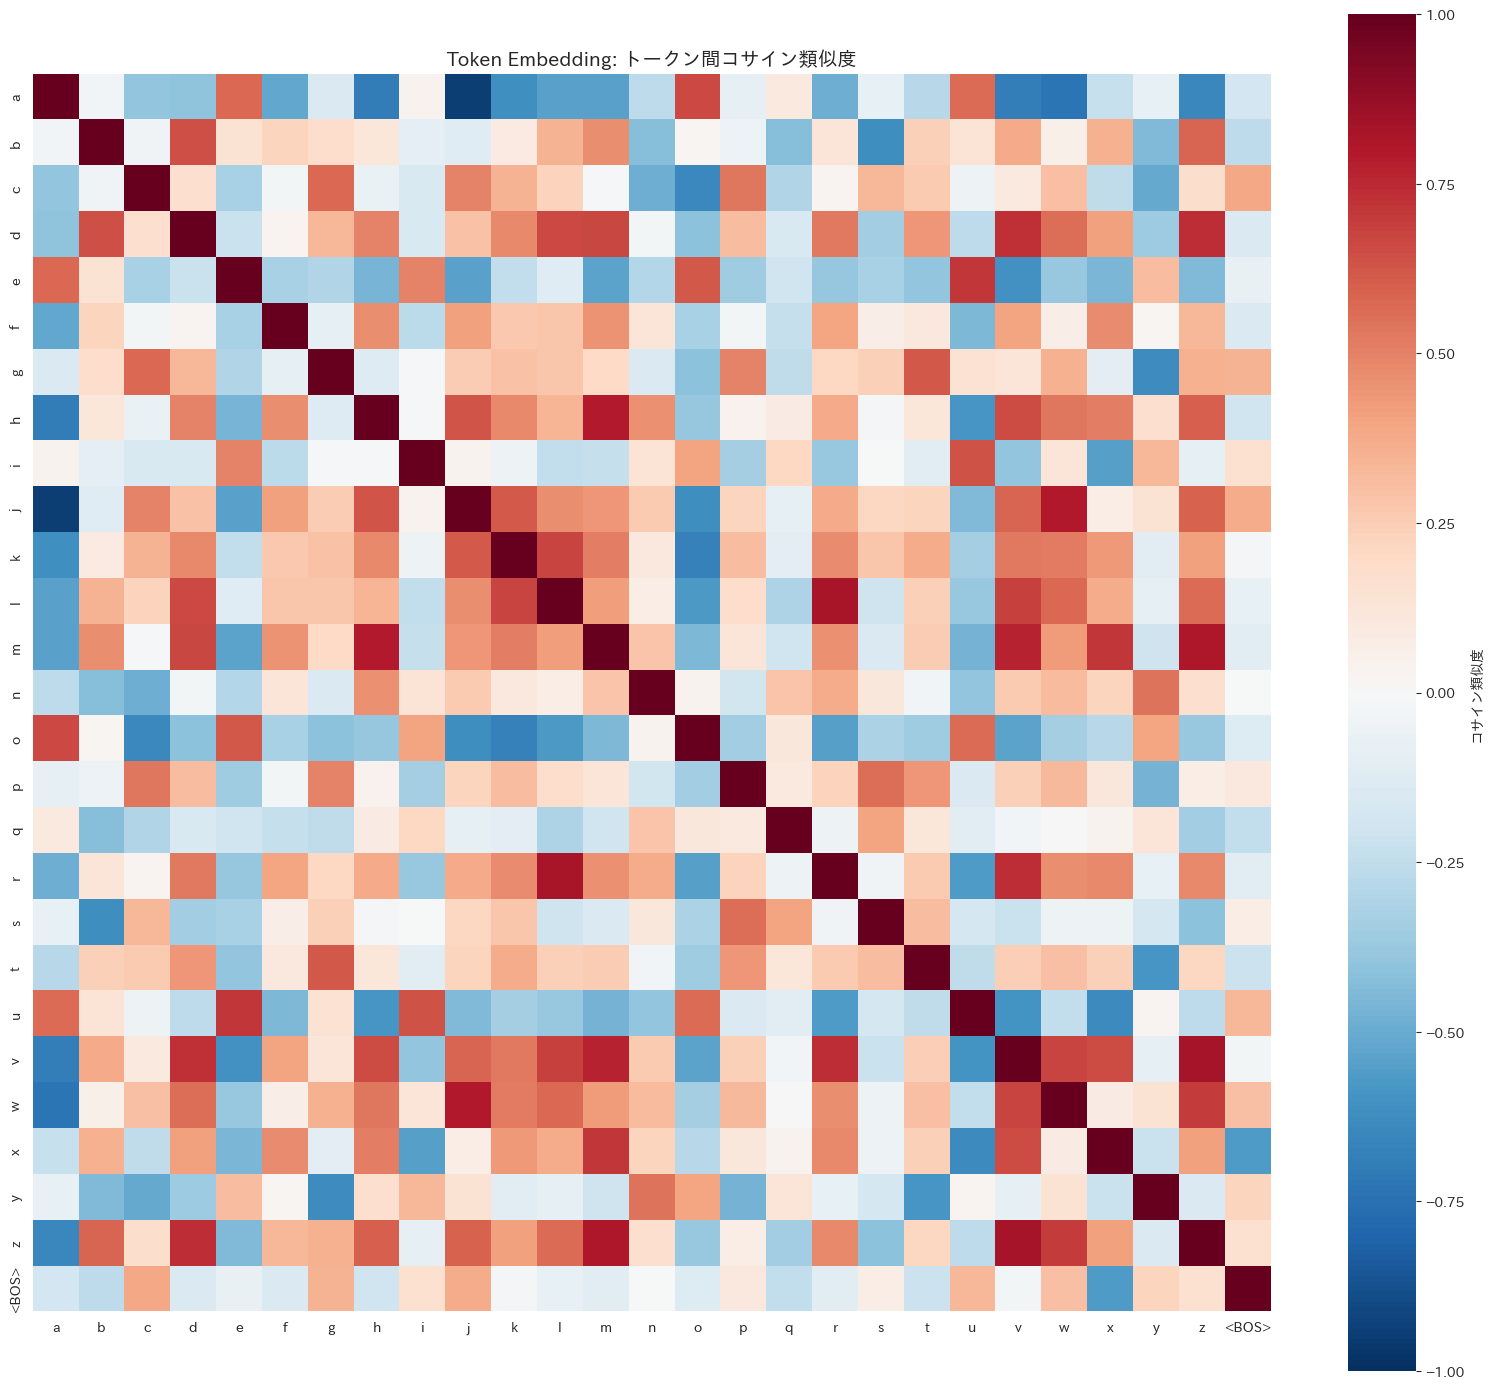


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
対応する括弧ペアのコサイン類似度
( と ): (データセットに含まれていません)
[ と ]: (データセットに含まれていません)
{ と }: (データセットに含まれていません)


In [7]:
# コサイン類似度を計算
cos_sim = cosine_similarity(token_emb)

# ヒートマップで可視化
plt.figure(figsize=(16, 14))
token_labels = analyzer.uchars + ['<BOS>']
sns.heatmap(
    cos_sim,
    xticklabels=token_labels,
    yticklabels=token_labels,
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'コサイン類似度'},
    square=True
)
plt.title('Token Embedding: トークン間コサイン類似度', fontsize=14)
plt.tight_layout()
plt.show()

# 括弧ペアの類似度を特に確認
print("\n=" * 50)
print("対応する括弧ペアのコサイン類似度")
print("=" * 50)

bracket_pairs = [('(', ')'), ('[', ']'), ('{', '}')]

for open_br, close_br in bracket_pairs:
    if open_br in analyzer.uchars and close_br in analyzer.uchars:
        idx_open = analyzer.uchars.index(open_br)
        idx_close = analyzer.uchars.index(close_br)
        similarity = cos_sim[idx_open, idx_close]
        print(f"{open_br} と {close_br}: {similarity:.4f}")
    else:
        print(f"{open_br} と {close_br}: (データセットに含まれていません)")

## セクション2：Position Embedding可視化

### 2-1: 2次元投影（PCA）

In [8]:
# Position Embeddingを取得
pos_emb = analyzer.get_embedding_matrix('position')
print(f"Position Embedding shape: {pos_emb.shape}")

# PCAで2次元に投影
pca_pos = PCA(n_components=2)
pos_emb_2d = pca_pos.fit_transform(pos_emb)
print(f"PCA説明分散比: {pca_pos.explained_variance_ratio_}")
print(f"累積寄与率: {sum(pca_pos.explained_variance_ratio_):.2%}")

# データフレームを作成
pos_df = pd.DataFrame({
    'PC1': pos_emb_2d[:, 0],
    'PC2': pos_emb_2d[:, 1],
    'position': range(analyzer.block_size)
})

Position Embedding shape: (16, 16)
PCA説明分散比: [0.53625271 0.15722223]
累積寄与率: 69.35%


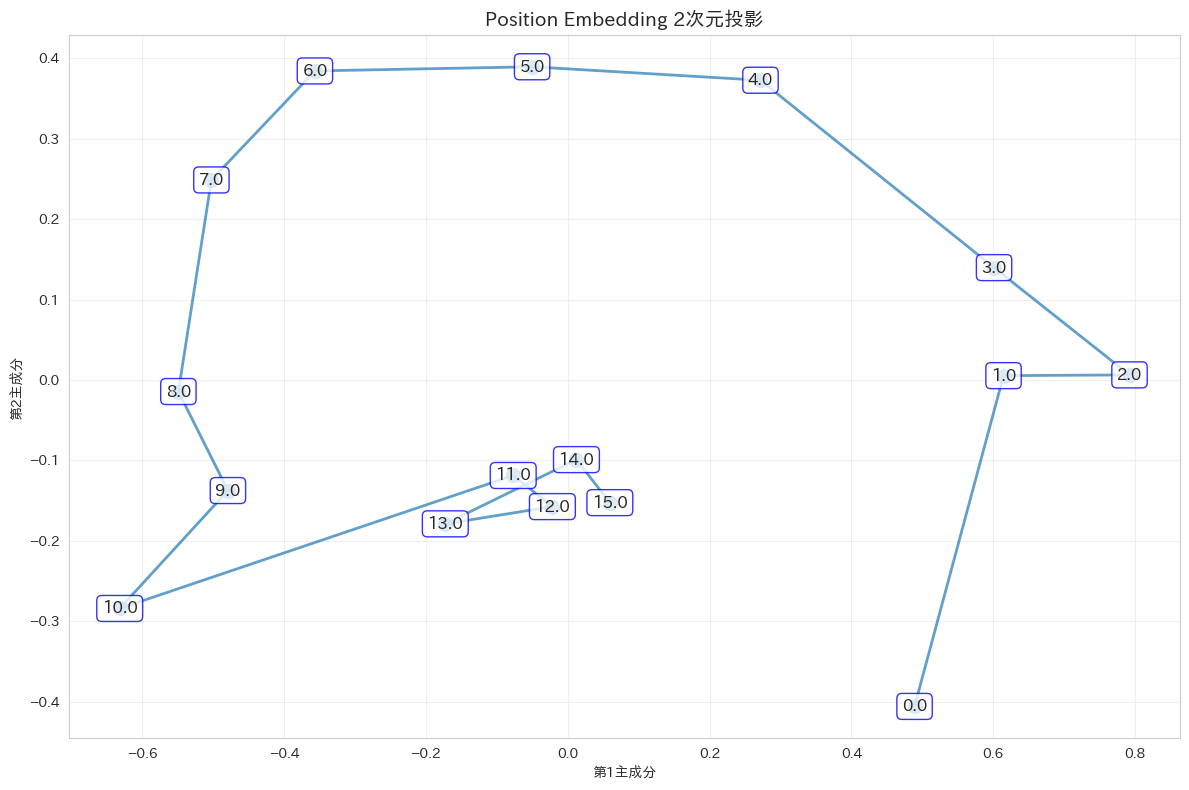

In [9]:
# 散布図を作成（位置を線で接続）
plt.figure(figsize=(12, 8))
plt.plot(pos_df['PC1'], pos_df['PC2'], 'o-', markersize=10, linewidth=2, alpha=0.7)

# 各点にラベルを表示
for idx, row in pos_df.iterrows():
    plt.text(row['PC1'], row['PC2'], str(row['position']), 
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='blue'))

plt.title('Position Embedding 2次元投影', fontsize=14)
plt.xlabel('第1主成分')
plt.ylabel('第2主成分')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2-2: 位置別の重み分布

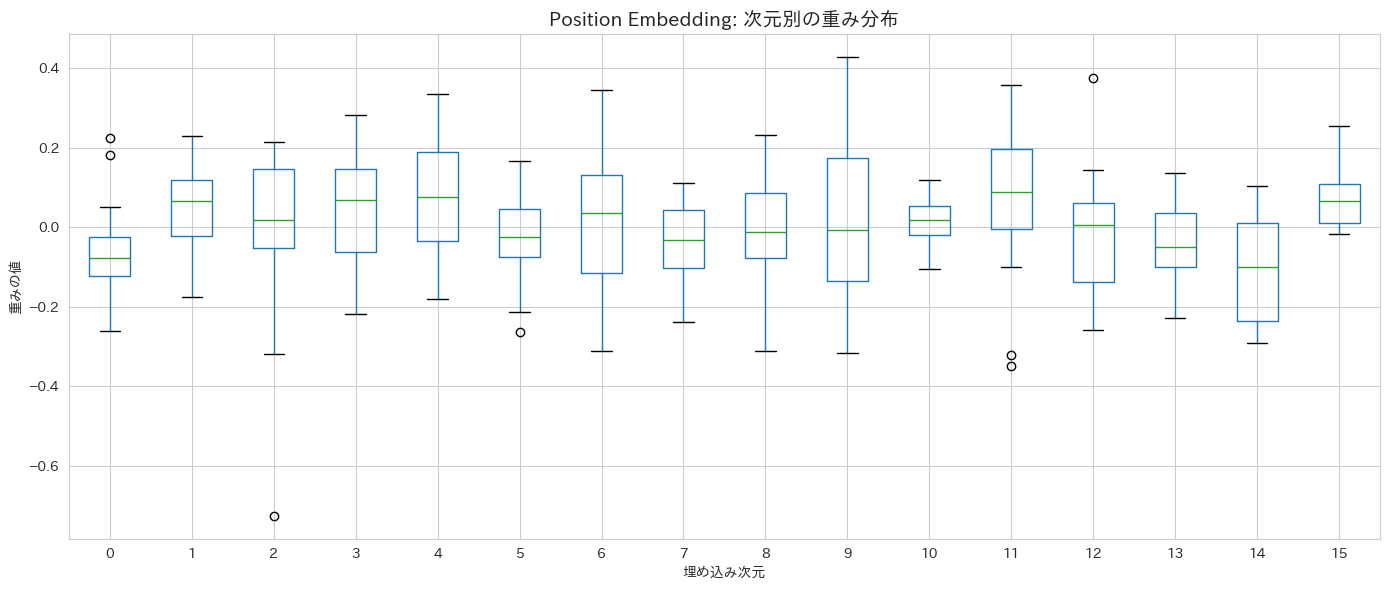

In [10]:
# 各次元の重み分布を可視化
plt.figure(figsize=(14, 6))
pos_emb_df = pd.DataFrame(pos_emb)
pos_emb_df.boxplot()
plt.title('Position Embedding: 次元別の重み分布', fontsize=14)
plt.xlabel('埋め込み次元')
plt.ylabel('重みの値')
plt.tight_layout()
plt.show()

## まとめ

このNotebookでは、Embedding空間の分布を可視化しました：

### Token Embedding
- 音韻的特徴とPython記号の構造による11カテゴリの色分けで可視化
- 対応する括弧（[と]、(と)、{と}）のEmbedding類似度を確認
- 母音、子音などの音韻的特徴によるクラスタリングを確認
- Python演算子、区切り記号などの記号がどのように表現されているかを確認

### Position Embedding
- 位置情報が埋め込み空間でどのように表現されているか
- 連続する位置が滑らかに遷移しているかを確認

### 重要な観察
- 構造的に関連する記号（括弧ペア）が近いEmbeddingを持つか
- 音韻的に類似した文字が近い位置にクラスタリングされているか

次のNotebookでは、推論プロセスをアニメーションで可視化します。